In [1]:
import scipy.io
import jax.numpy as np
from scipy.io import loadmat 
import numpy as onp
import matplotlib.pyplot as plt 
import os
import shutil
from PIL import Image
from inrmri.bart import bart_acquisition_from_arrays
from inrmri.data_harvard import get_csmaps_and_mask, get_reference_reco
import pandas as pd
from jax import jit, vmap, random
from inrmri.dip import TimeDependant_DIP_Net, helix_generator, circle_generator
from inrmri.new_radon import ForwardRadonOperator
from inrmri.fourier import fastshiftfourier, get_freqs
from inrmri.basic_nn import weighted_loss 
from inrmri.utils import to_complex, is_inside_of_radial_lim, meshgrid_from_subdiv_autolims, total_variation_batch_complex, save_matrix_and_dict_in_zpy, load_matrix_and_dict_from_zpy    
from inrmri.utils import create_exp_file_name, total_variation_complex
import optax 
from inrmri.metrics_rd import mean_psnr, mean_ssim, mean_artifact_power

In [2]:
from inrmri.utils_rdls import seconds_to_min_sec_format, filter_and_get_columns, apply_transform

In [4]:
from inrmri.image_processor import BeforeLinRegNormalizer
from inrmri.basic_plotting import full_halph_FOV_space_time 
from inrmri.image_processor import reduce_FOV 

In [5]:
from inrmri.utils_rdls import safe_normalize, get_center

## General

In [7]:
total_slices = 8
num_frames   = 30
base_path    = '/mnt/workspace/datasets/pulseqCINE/'

In [ ]:
dict_plot = {
    'DATA_1.5T': {
        'GC': {
            1: {'crop_ns': [35,50,55,30], 'saturation': 0.25},
            2: {'crop_ns': [35,50,55,30], 'saturation': 0.25}, # done
            3: {'crop_ns': [32,57,55,27], 'saturation': 0.3}, # done
            4: {'crop_ns': [32,47,57,27], 'saturation': 0.4}, # done
            5: {'crop_ns': [25,55,50,30], 'saturation': 0.5}, # done
            6: {'crop_ns': [23,55,48,30], 'saturation': 0.5}, # done
            7: {'crop_ns': [25,55,50,30], 'saturation': 0.5},
            8: {'crop_ns': [25,55,50,30], 'saturation': 0.5},
        },
        'CM': {
            1: {'crop_ns': [32,43,30,40], 'saturation': 0.4},
            2: {'crop_ns': [32,43,30,40], 'saturation': 0.4},
            3: {'crop_ns': [32,43,30,40], 'saturation': 0.4}, # done
            4: {'crop_ns': [35,40,35,40], 'saturation': 0.4}, # done
            5: {'crop_ns': [35,40,35,40], 'saturation': 0.4}, # done
            6: {'crop_ns': [35,40,40,34], 'saturation': 0.4}, # done
            7: {'crop_ns': [35,40,35,40], 'saturation': 0.4}, # done
            8: {'crop_ns': [35,40,35,40], 'saturation': 0.4},
        },
        'DW': {
            1: {'crop_ns': [28,45,50,25], 'saturation': 0.6},
            2: {'crop_ns': [28,45,50,25], 'saturation': 0.6}, # done
            3: {'crop_ns': [28,45,50,25], 'saturation': 0.6}, # done
            4: {'crop_ns': [28,45,50,25], 'saturation': 0.6}, # done
            5: {'crop_ns': [30,45,50,25], 'saturation': 0.6}, # done
            6: {'crop_ns': [30,45,50,25], 'saturation': 0.6},
            7: {'crop_ns': [30,45,50,25], 'saturation': 0.6}, 
            8: {'crop_ns': [30,45,50,25], 'saturation': 0.6},
        },
    },
    'DATA_0.55T': {
        'MP': {
            1: {'crop_ns': [40,35,35,40], 'saturation': 0.3}, # done
            2: {'crop_ns': [40,35,35,40], 'saturation': 0.3}, # done
            3: {'crop_ns': [40,35,35,40], 'saturation': 0.3}, # done
            4: {'crop_ns': [40,35,35,40], 'saturation': 0.3}, # done
            5: {'crop_ns': [40,40,40,40], 'saturation': 0.3}, # done
            6: {'crop_ns': [40,40,40,40], 'saturation': 0.3},
            7: {'crop_ns': [40,40,40,40], 'saturation': 0.3},
            8: {'crop_ns': [40,40,40,40], 'saturation': 0.3},
        },
        'FH': {
            1: {'crop_ns': [32,40,35,35], 'saturation': 0.3}, 
            2: {'crop_ns': [32,40,35,35], 'saturation': 0.3}, # done
            3: {'crop_ns': [32,40,33,38], 'saturation': 0.3}, # done
            4: {'crop_ns': [32,40,33,38], 'saturation': 0.3}, # done
            5: {'crop_ns': [32,40,33,38], 'saturation': 0.3}, # done
            6: {'crop_ns': [32,40,33,38], 'saturation': 0.3}, # done
            7: {'crop_ns': [32,40,33,38], 'saturation': 0.3},
            8: {'crop_ns': [32,40,33,38], 'saturation': 0.3},
        }, 
        'TC': {
            1: {'crop_ns': [32,42,48,37], 'saturation': 0.2},
            2: {'crop_ns': [40,40,45,40], 'saturation': 0.2}, # done
            3: {'crop_ns': [40,40,45,40], 'saturation': 0.2}, # done
            4: {'crop_ns': [40,40,45,40], 'saturation': 0.2}, # done
            5: {'crop_ns': [40,45,45,40], 'saturation': 0.2}, # done
            6: {'crop_ns': [40,45,45,40], 'saturation': 0.25}, # done
            7: {'crop_ns': [40,45,45,40], 'saturation': 0.25},
            8: {'crop_ns': [40,45,45,40], 'saturation': 0.25},
        }, 
        'RF': {
            1: {'crop_ns': [38,42,45,40], 'saturation': 0.2},
            2: {'crop_ns': [38,42,45,40], 'saturation': 0.2}, # done
            3: {'crop_ns': [38,42,45,40], 'saturation': 0.2}, # done
            4: {'crop_ns': [38,42,45,40], 'saturation': 0.25}, # done
            5: {'crop_ns': [38,42,45,40], 'saturation': 0.25}, # done
            6: {'crop_ns': [38,42,45,40], 'saturation': 0.25}, # done
            7: {'crop_ns': [38,42,45,40], 'saturation': 0.25},
            8: {'crop_ns': [38,42,45,40], 'saturation': 0.25},
        }, 
        'JB': {
            1: {'crop_ns': [40,38,48,30], 'saturation': 0.4},
            2: {'crop_ns': [40,38,48,30], 'saturation': 0.4}, # done
            3: {'crop_ns': [40,38,48,30], 'saturation': 0.5}, # done
            4: {'crop_ns': [40,38,48,30], 'saturation': 0.5}, # done
            5: {'crop_ns': [40,38,48,30], 'saturation': 0.5}, # done
            6: {'crop_ns': [40,38,48,30], 'saturation': 0.5}, # done
            7: {'crop_ns': [40,38,48,30], 'saturation': 0.5},
            8: {'crop_ns': [40,38,48,30], 'saturation': 0.5},
        }, 
        'FE': {
            1: {'crop_ns': [40,40,42,38], 'saturation': 0.25},
            2: {'crop_ns': [40,40,42,38], 'saturation': 0.25}, # done
            3: {'crop_ns': [40,40,42,38], 'saturation': 0.25}, # done
            4: {'crop_ns': [38,42,38,36], 'saturation': 0.25}, # done
            5: {'crop_ns': [36,42,38,36], 'saturation': 0.35}, # done 
            6: {'crop_ns': [36,42,38,36], 'saturation': 0.35}, # done 
            7: {'crop_ns': [36,42,38,36], 'saturation': 0.4}, # done
            8: {'crop_ns': [36,42,38,36], 'saturation': 0.5}, # done
        }, 
        'DB': {
            1: {'crop_ns': [34,40,45,30], 'saturation': 0.25},
            2: {'crop_ns': [34,40,45,30], 'saturation': 0.25}, # done
            3: {'crop_ns': [34,40,45,30], 'saturation': 0.25}, # done
            4: {'crop_ns': [34,40,45,30], 'saturation': 0.25}, # done
            5: {'crop_ns': [34,40,45,30], 'saturation': 0.25}, # done
            6: {'crop_ns': [34,42,45,30], 'saturation': 0.25}, # done
            7: {'crop_ns': [34,42,45,30], 'saturation': 0.25},
            8: {'crop_ns': [34,42,45,30], 'saturation': 0.25},
        }, 
        'FP': {
            1: {'crop_ns': [35,42,45,30], 'saturation': 0.35},
            2: {'crop_ns': [35,42,45,30], 'saturation': 0.35}, # done
            3: {'crop_ns': [35,42,45,30], 'saturation': 0.35}, # done
            4: {'crop_ns': [35,42,45,30], 'saturation': 0.35}, # done
            5: {'crop_ns': [35,42,45,30], 'saturation': 0.35},
            6: {'crop_ns': [35,42,45,30], 'saturation': 0.35},
            7: {'crop_ns': [35,42,45,30], 'saturation': 0.35}, # done
            8: {'crop_ns': [35,42,45,30], 'saturation': 0.35},
        }, 
        'AA': {
            1: {'crop_ns': [35,42,45,30], 'saturation': 0.3},
            2: {'crop_ns': [35,42,45,30], 'saturation': 0.3}, # done
            3: {'crop_ns': [35,42,45,30], 'saturation': 0.3}, # done
            4: {'crop_ns': [35,42,45,30], 'saturation': 0.3}, # done
            5: {'crop_ns': [35,42,45,30], 'saturation': 0.3}, # done
            6: {'crop_ns': [35,42,45,30], 'saturation': 0.3}, # done
            7: {'crop_ns': [35,42,45,30], 'saturation': 0.3},
            8: {'crop_ns': [35,42,45,30], 'saturation': 0.3},
        }, 
        'DP': {
            1: {'crop_ns': [25,60,40,35], 'saturation': 0.2},
            2: {'crop_ns': [25,60,40,35], 'saturation': 0.2}, # done
            3: {'crop_ns': [25,55,40,35], 'saturation': 0.2}, # done
            4: {'crop_ns': [25,55,40,35], 'saturation': 0.2}, # done
            5: {'crop_ns': [25,55,40,35], 'saturation': 0.2}, # done
            6: {'crop_ns': [25,55,40,35], 'saturation': 0.2}, # done
            7: {'crop_ns': [25,55,40,40], 'saturation': 0.2}, # done
            8: {'crop_ns': [25,55,40,40], 'saturation': 0.2},
        }, 
    }
}

dict_trans = {
    'DATA_1.5T': {
        'GC': {
            'flip_h': False,
            'flip_v': False,
            'rot': 0,
        },
        'CM': {
            'flip_h': False,
            'flip_v': False,
            'rot': 0,
        },
        'DW': {
            'flip_h': False,
            'flip_v': False,
            'rot': 0,
        },
    },
    'DATA_0.55T': {
        'MP': {
            'flip_h': True,
            'flip_v': True,
            'rot': 0,
        },
        'FH': {
            'flip_h': True,
            'flip_v': True,
            'rot': 0,
        }, 
        'TC': {
            'flip_h': True,
            'flip_v': True,
            'rot': 0,
        }, 
        'RF': {
            'flip_h': True,
            'flip_v': True,
            'rot': 0,
        }, 
        'JB': {
            'flip_h': True,
            'flip_v': True,
            'rot': 0,
        }, 
        'FE': {
            'flip_h': True,
            'flip_v': False,
            'rot': 0,
        }, 
        'DB': {
            'flip_h': True,
            'flip_v': False,
            'rot': 0,
        },
        'FP': {
            'flip_h': False,
            'flip_v': False,
            'rot': 0,
        },
        'AA': {
            'flip_h': True,
            'flip_v': False,
            'rot': 0,
        },
        'DP': {
            'flip_h': False,
            'flip_v': False,
            'rot': 0,
        },
    }
}


gt_trans = {
    'DATA_0.55T': {
        'FP': {
            'flip_h': False,
            'flip_v': False,
            'rot': 90,
        },
        'DP': {
            'flip_h': True,
            'flip_v': True,
            'rot': 0,
        },
    }
}


## Define volunteer and experiment

In [8]:
volunteer    = 'FH'
dataset      = 'DATA_0.55T'
# --- PATH ---
base_folder           = base_path + dataset + '/' + volunteer + '/'
train_data_folder     = base_folder + 'traindata/'
path_stDIP            = base_folder + 'stDIP/'

In [9]:
experiment_name = 'total_kiter_lambda_denoise_reg'
csv_path = path_stDIP + experiment_name + ".csv"
df = pd.read_csv(path_stDIP + experiment_name + ".csv" , delimiter=';')
df_summary = pd.read_csv(path_stDIP + experiment_name + "_summary.csv" , delimiter=';')

In [10]:
df.head(2)

,total_kiter,lambda_denoise_reg,duration [s],duration [min],duration,it,loss,mean_var,time,var,...,training_name,training_folder,slice,log_var,log_ssim,log_psnr,log_ap,log_loss,log_it,log_time
0,2000,1.000000e-08,847.129159,14.118819,0h 14m 7.13s,1899,0.385121,0.000059,805.139151,0.000076,...,total_kiter=2000__lambda_denoise_reg=1e-08,/mnt/researchers/claudia-prieto/datasets/pulse...,1,"[0.013580676168203354, 0.0005907873273827136, ...","[0.6755348443984985, 0.6787824630737305, 0.705...","[21.470991134643555, 21.13868522644043, 21.685...","[0.46193864941596985, 0.49867168068885803, 0.4...","[0.6311036348342896, 0.6174883246421814, 0.568...","[49, 99, 149, 199, 249, 299, 349, 399, 449, 49...","[57.59644293785095, 77.59578824043274, 97.8104..."
1,2000,1.000000e-07,869.151427,14.485857,0h 14m 29.15s,1499,0.322795,0.000064,652.926747,0.000088,...,total_kiter=2000__lambda_denoise_reg=1e-07,/mnt/researchers/claudia-prieto/datasets/pulse...,1,"[0.013684716075658798, 0.001083968672901392, 0...","[0.5401424765586853, 0.6205931901931763, 0.709...","[19.672962188720703, 20.50688362121582, 21.840...","[0.6988555192947388, 0.5767598152160645, 0.424...","[0.7324085235595703, 0.5829476118087769, 0.543...","[49, 99, 149, 199, 249, 299, 349, 399, 449, 49...","[54.22360420227051, 74.53957605361938, 94.9116..."


## Select slice and parameters to evaluate

In [11]:
slice_num             = 2
dataset_name          = 'slice_' + str(slice_num) + '_' + str(total_slices) +'_nbins' + str(num_frames)
path_dataset          = train_data_folder + dataset_name + '.npz'
exp_folder_path       = path_stDIP + dataset_name + '/' + experiment_name + '/'

In [12]:
data         = onp.load(path_dataset)
recon_grasp  = data["recon_grasp"]
recon_sense  = data["recon_sense"]
recon_fs     = data["recon_fs"]
time_grasp   = data["time_grasp"]
time_sense   = data["time_sense"]

recon_grasp    = get_center(recon_grasp) 
recon_sense    = get_center(recon_sense)
recon_fs       = get_center(recon_fs) 

recon_grasp    = safe_normalize(recon_grasp) 
recon_sense    = safe_normalize(recon_sense) 
recon_fs       = safe_normalize(recon_fs) 

2025-06-17 15:50:45.717900: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [13]:
time_grasp, seconds_to_min_sec_format(time_grasp)

(array(115.63238096), '01:56')

In [14]:
list(data.keys())

['Y_data',
 'X_data',
 'csm',
 'hollow_mask',
 'spclim',
 'recon_grasp',
 'recon_sense',
 'time_grasp',
 'time_sense',
 'recon_fs',
 'time_recon_fs']

In [15]:
reference_metrics = {
    'time_grasp':     time_grasp,
    'time_sense':     time_sense,
    'time_grasp_str': seconds_to_min_sec_format(time_grasp),
    'time_sense_str': seconds_to_min_sec_format(time_sense),
    'psnr_grasp':     mean_psnr(recon_grasp, recon_fs),
    'psnr_sense':     mean_psnr(recon_sense, recon_fs),
    'ssim_grasp':     mean_ssim(recon_grasp, recon_fs),
    'ssim_sense':     mean_ssim(recon_sense, recon_fs),
    'psnr_grasp_str':     str(round(float(mean_psnr(recon_grasp, recon_fs)),1)),
    'psnr_sense_str':     str(round(float(mean_psnr(recon_sense, recon_fs)),1)),
    'ssim_grasp_str':     str(round(float(mean_ssim(recon_grasp, recon_fs)),2)),
    'ssim_sense_str':     str(round(float(mean_ssim(recon_sense, recon_fs)),2)),
}

In [16]:
reference_metrics

{'time_grasp': array(115.63238096),
 'time_sense': array(27.10608149),
 'time_grasp_str': '01:56',
 'time_sense_str': '00:27',
 'psnr_grasp': Array(21.845263, dtype=float32),
 'psnr_sense': Array(22.42137, dtype=float32),
 'ssim_grasp': Array(0.6985587, dtype=float32),
 'ssim_sense': Array(0.70135707, dtype=float32),
 'psnr_grasp_str': '21.8',
 'psnr_sense_str': '22.4',
 'ssim_grasp_str': '0.7',
 'ssim_sense_str': '0.7'}

In [17]:
#recon_grasp    = safe_normalize(recon_grasp) 
#recon_sense    = safe_normalize(recon_sense) 
#recon_fs       = safe_normalize(recon_fs) 

## **Get DIP reconstructions**

In [18]:
target_columns = ['training_name', 'psnr', 'ssim', 'it', 'duration [min]']

params_1 = {
    'total_kiter':2000,
    'lambda_denoise_reg':1e-7,
    'slice':slice_num,
}
params_2 = {
    'total_kiter':3000,
    'lambda_denoise_reg':1e-7,
    'slice':slice_num,
}
params_3 = {
    'total_kiter':4000,
    'lambda_denoise_reg':1e-7,
    'slice':slice_num,
}

output_1 = filter_and_get_columns(df, params_1, target_columns)[0]
output_2 = filter_and_get_columns(df, params_2, target_columns)[0]
output_3 = filter_and_get_columns(df, params_3, target_columns)[0]

In [19]:
output_1['recon']     = onp.load(exp_folder_path + output_1['training_name'] + '/' + 'best_recon.npz', allow_pickle=True)['best_recon']
output_2['recon']     = onp.load(exp_folder_path + output_2['training_name'] + '/' + 'best_recon.npz', allow_pickle=True)['best_recon']
output_3['recon']     = onp.load(exp_folder_path + output_3['training_name'] + '/' + 'best_recon.npz', allow_pickle=True)['best_recon']

In [21]:
output_1['name'] = r'$\mathbf{ST\text{-}DIP}$' + '\npsnr: ' + str(round(output_1['psnr'],1))       + '\nssim: ' + str(round(output_1['ssim'],2))       + '\ntime: ' + seconds_to_min_sec_format(output_1['duration [min]']*60)
output_2['name'] = r'$\mathbf{ST\text{-}DIP}$' + '\npsnr: ' + str(round(output_2['psnr'],1))       + '\nssim: ' + str(round(output_2['ssim'],2))       + '\ntime: ' + seconds_to_min_sec_format(output_2['duration [min]']*60)
output_3['name'] = r'$\mathbf{ST\text{-}DIP}$' + '\npsnr: ' + str(round(output_3['psnr'],1))       + '\nssim: ' + str(round(output_3['ssim'],2))       + '\ntime: ' + seconds_to_min_sec_format(output_3['duration [min]']*60)
name_grasp =       r'$\mathbf{GRASP}$'         + '\npsnr: ' + reference_metrics['psnr_grasp_str']  + '\nssim: ' + reference_metrics['ssim_grasp_str']  + '\ntime: ' + reference_metrics['time_grasp_str']
name_sense =       r'$\mathbf{SENSE}$'         + '\npsnr: ' + reference_metrics['psnr_sense_str']  + '\nssim: ' + reference_metrics['ssim_sense_str']  + '\ntime: ' + reference_metrics['time_sense_str']

In [22]:
path_stDIP + experiment_name + '_slice' + str(slice_num)

'/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/FH/stDIP/total_kiter_lambda_denoise_reg_slice2'

## **Plot**

In [24]:
output_1['recon_trans'] = apply_transform(output_1['recon'], dataset, volunteer, dict_trans)
output_2['recon_trans'] = apply_transform(output_2['recon'], dataset, volunteer, dict_trans)
output_3['recon_trans'] = apply_transform(output_3['recon'], dataset, volunteer, dict_trans)
recon_grasp_trans = apply_transform(recon_grasp, dataset, volunteer, dict_trans)
recon_sense_trans = apply_transform(recon_sense, dataset, volunteer, dict_trans)
if volunteer in ['FP', 'DP']:
    recon_fs_trans = apply_transform(recon_fs, dataset, volunteer, gt_trans)
else:
    recon_fs_trans = apply_transform(recon_fs, dataset, volunteer, dict_trans)

In [25]:
matrix_list  = [recon_fs_trans, output_1['recon_trans'], output_2['recon_trans'], output_3['recon_trans'] , recon_grasp_trans, recon_sense_trans]
matrix_names = ['GT', output_1['name'], output_2['name'], output_3['name'] , name_grasp , name_sense ]

crop_ns       = dict_plot[dataset][volunteer][slice_num]['crop_ns']
saturation    =  dict_plot[dataset][volunteer][slice_num]['saturation']
frame = 0
print(crop_ns, saturation)

[32, 40, 35, 35] 0.3


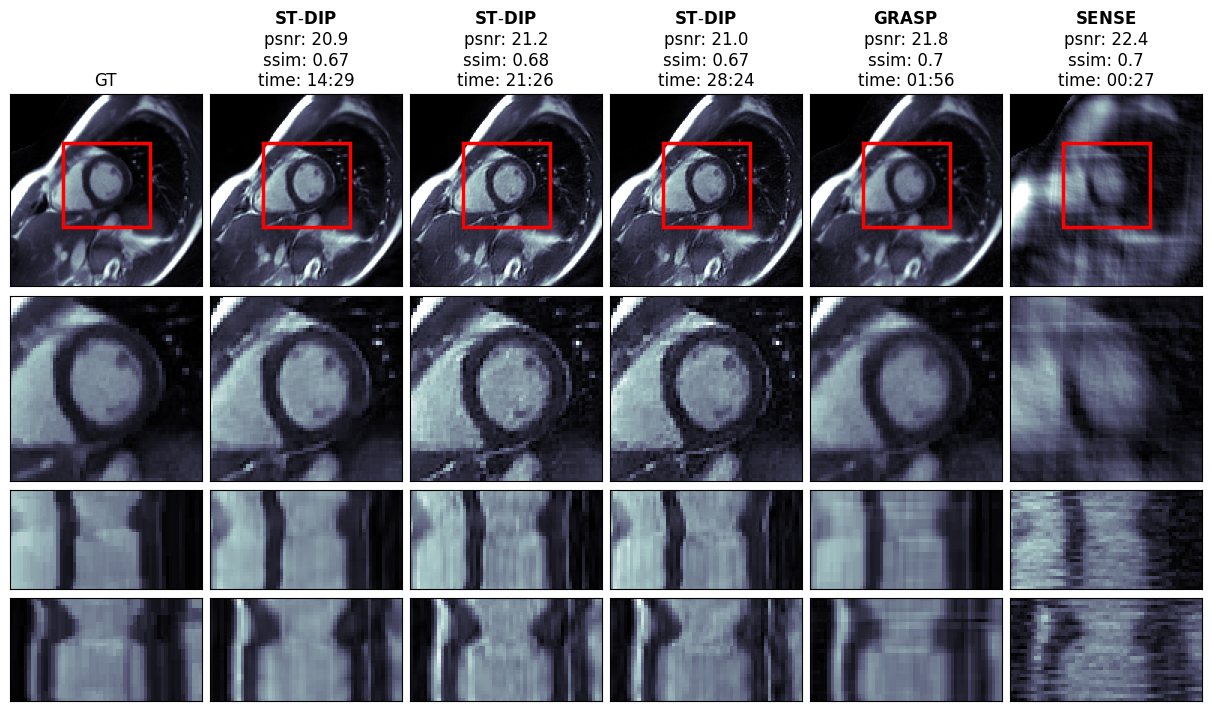

In [26]:
fig, axs = full_halph_FOV_space_time(matrix_list, crop_ns=crop_ns, saturation=saturation, frame=frame, xy_proportion=(2,7))
for ax, title in zip(axs, matrix_names):
    ax[0].set_title(title)
fig.savefig( path_stDIP + experiment_name + '_slice' + str(slice_num) + ".png", dpi=300, bbox_inches='tight')